In [1]:
%matplotlib notebook
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import datetime
import random

In [5]:
# %matplotlib qt5

#### Pytorch中Normal分布的sample()和rsample()的核心区别在于梯度传播方式
- sample()：直接从分布中采样，是不可微分的操作
- rsample()：使用重参数化技巧(reparameterization trick)，通过标准正太噪声+参数变换实现采样，是可以微分的

##### 1. 数学原理
假设我们有正态分布$\mathcal{N}(\mu, \sigma^2)$
- sample()：直接从目标分布采样$z \sim \mathcal{N}(\mu, \sigma^2)$
- rsample()：先采样标准正态噪声$\epsilon \sim \mathcal{N}(0, 1)$，再通过变换得到目标样本$z = \mu + \sigma \cdot \epsilon$

##### 2. 梯度传播
- sample()：采样过程是随机的，梯度无法通过采样步骤反向传播
- rsample()：梯度可以通过变换公式直接传播到参数$\mu$和$\sigma$

##### 3. 适用场景
- sample()：仅用于需要随机样本但不关心参数梯度的场景
- rsample()：适用于需要对分布参数求梯度的情况，如变分自编码器 (VAE)、强化学习等

In [13]:
import torch.distributions as dist

# 创建正态分布
mu = torch.tensor([0.0], requires_grad=True)
sigma = torch.tensor([1.0], requires_grad=True)
normal = dist.Normal(mu, sigma)

def test_sample(dist):
    # 报错
    # 使用sample() - 不可微分
    z_sample = dist.sample()
    loss_sample = (z_sample**2).sum()
    loss_sample.backward()
    return mu.grad, sigma.grad

def test_rsample(dist):
    # 使用rsample() - 可微分
    z_rsample = dist.rsample()
    loss_rsample = (z_rsample**2).sum()
    loss_rsample.backward()
    # mu.grad 和 sigma.grad 都有值
    return mu.grad, sigma.grad

test_rsample(normal)
# test_sample(normal)

(tensor([-4.0781]), tensor([8.3154]))

In [17]:
class Actor(nn.Module):
    def __init__(self, n_state, n_action, hidden_size = 64):
        super(Actor, self).__init__()
        
        self.fc1 = torch.nn.Linear(n_state, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc_mean = torch.nn.Linear(hidden_size, n_action)
        self.fc_std = torch.nn.Linear(hidden_size, n_action)

        self.action_bound = 1

    def forward(self, state):
        x = self.fc1(state)
        x = self.fc2(F.relu(x))
        mu = self.fc_mean(F.relu(x))
        std = F.softplus(self.fc_std(F.relu(x)))

        normal_dist = dist.Normal(mu, std)
        sample = normal_dist.rsample()
        log_prob = dist.log_prob(sample)

        action = torch.tanh(sample)
        # 修正tanh带来的概率密度变化，确保策略梯度正确
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-6)
        action = action * self.action_bound
        return action, log_prob

        
class Qvalue(nn.Module):
    def __init__(self, n_state, n_action, hidden_size=64):
        super(Qvalue, self).__init__()

        self.fc1 = torch.nn.Linear(n_state + n_action, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, 1)

    def forward(self, state):
        x = self.fc1(toch.cat([x,a],dim=1))
        x = self.fc2(F.relu(x))
        x = self.fc3(F.relu(x))
        return x


class SAC:
    def __init__(self, n_state, n_action, n_hidden, lr_actor, lr_q, alpha, tau, gamma):
        self.actor = Actor(n_state, n_action)
        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
        
        self.q1 = Qvalue(n_state, n_action)
        self.q1_target = Qvalue(n_state, n_action)
        self.q1_opt = torch.optim.Adam(self.q1.parameters(), lr=lr_q)

        self.q2 = Qvalue(n_state, n_action)
        self.q2_target = Qvalue(n_state, n_action)
        self.q2_opt = torch.optim.Adam(self.q2.parameters(), lr=lr_q)

        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())


        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha
        self.device = "cpu"

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action, log_prob = self.actor(state)
        return [action.item()]

    def compute_q_target(self, rewards, next_states, dones):
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob

        q1 = self.q1_target(next_states, next_actions)
        q2 = self.q2_target(next_states, next_actions)
        next_value = torch.min(q1_target, q2_target) + self.alpha * entropy

        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data*(1.0 - self.tau) + param.data*self.tau)

    def update(self, transition_dict):
        

        

SyntaxError: invalid syntax (2506190702.py, line 67)

In [7]:
actor_lr = 1e-3
critic_lr = 1e-3
num_episodes = 1000
hidden = 128

gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2

device = "cpu"
env_name = "MountainCarContinuous-v0"
# env_name = "Pendulum-v1"


env = gym.make(env_name)
torch.manual_seed(0)
print(f"state space:" , env.observation_space.sample())
print(f"action space: {env.action_space}")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = PPOContinuous(n_state=state_dim, n_action=action_dim, n_hidden=hidden,actor_lr=actor_lr, critic_lr=critic_lr, eps=eps,)

state space: [-0.7376029   0.00172105]
action space: Box(-1.0, 1.0, (1,), float32)
n_state=2, n_action=1, n_hidden=128


In [8]:
def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    episode_return = 0

    for epoch in range(num_episodes//100):
    
        for i in tqdm(range(100), position=0, desc=f"###{epoch} : {episode_return} "):
            episode_return = 0
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            state, _ = env.reset()
            done , truncated = False, False
            while not done and not truncated:
                action = agent.take_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                # reward = shaped_reward(state, reward)
                
    
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)


    return return_list
        
return_list = train_on_policy_agent(env, agent, num_episodes)

###0 : 0 :   0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/qj/rq98z_3924x5tz6c8ln97_mr0000gn/T/ipykernel_14598/2608933082.py:73: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)


###1 : -90.47109231524993 :   0%|          | 0/100 [00:00<?, ?it/s]

###2 : -98.93337129518854 :   0%|          | 0/100 [00:00<?, ?it/s]

###3 : 22.866248851602904 :   0%|          | 0/100 [00:00<?, ?it/s]

###4 : 5.088667514088328 :   0%|          | 0/100 [00:00<?, ?it/s]

###5 : 70.28455784967605 :   0%|          | 0/100 [00:00<?, ?it/s]

###6 : 68.62311542952443 :   0%|          | 0/100 [00:00<?, ?it/s]

###7 : 73.83638622060947 :   0%|          | 0/100 [00:00<?, ?it/s]

###8 : 68.04594047233394 :   0%|          | 0/100 [00:00<?, ?it/s]

###9 : 71.29390142212446 :   0%|          | 0/100 [00:00<?, ?it/s]

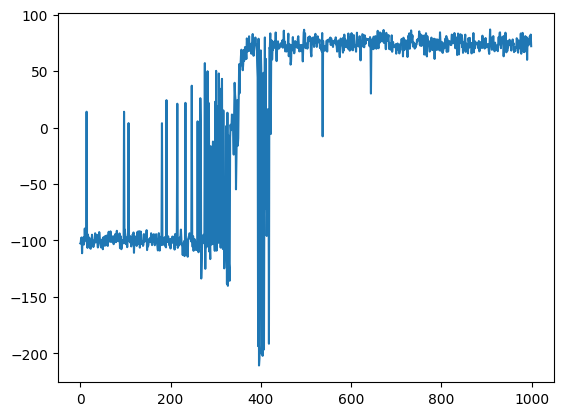

In [9]:
%matplotlib inline

plt.plot(return_list)
plt.show()

In [44]:
%matplotlib qt5

def test_agent(agent, env_name):
    env = gym.make(env_name, render_mode="human")

    state, info = env.reset()

    print(f"Starting observation: {state}")

    episode_over = False
    total_reward = 0
    action_list = []

    while not episode_over:
        action = agent.take_action(state, eval = True)
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        episode_over = terminated or truncated
        # print(f"{action=}")
        action_list.append(action)

    print(f"Episode finished! Total reward: {total_reward}")
    env.close()
    return action_list
    

action_list = test_agent(agent, env_name)

Starting observation: [-0.5603197  0.       ]
Episode finished! Total reward: 70.63409711524172


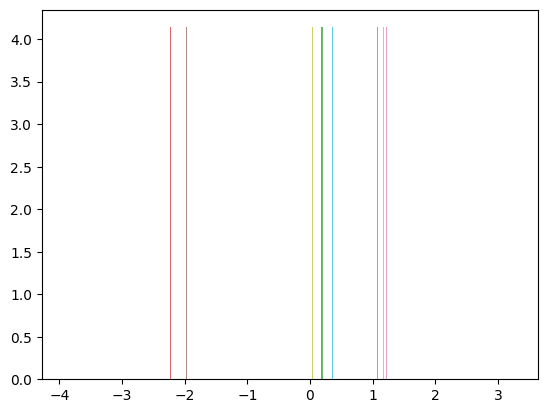

In [13]:
plt.hist(action_list, bins=30, density=True, alpha=0.7)
plt.show()